# Imports

In [1]:
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold

from dstoolkit.automl.classifier import AutoMLCatBoost, AutoMLCatBoostCV
from dstoolkit.model_analysis.classifier import plot_ks_curve

/home/junior/Documentos/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore")

## Functions

In [3]:
def generate_synthetic_binary_data(
    n_samples=10000,
    n_features=30,
    n_informative=5,
    n_redundant=10,
    n_repeated=0,
    n_classes=2,
    class_sep=0.5,
    flip_y=0.15,
    weights=[0.8, 0.2],
    test_size=0.2,
    valid_size=0.2,
    random_state=42
):
    """
    Gera uma base sintética binária com splits train/valid/test.
    Retorna: (X_train, y_train, X_valid, y_valid, X_test, y_test)
    """

    # ---------------------------
    # 1. Gerar base sintética
    # ---------------------------
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_repeated=n_repeated,
        n_classes=n_classes,
        class_sep=class_sep,
        flip_y=flip_y,
        weights=weights,
        random_state=random_state
    )

    # ---------------------------
    # 2. Train/Test
    # ---------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    # ---------------------------
    # 3. Train/Validation
    # ---------------------------
    valid_relative = valid_size / (1 - test_size)

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train,
        test_size=valid_relative,
        stratify=y_train,
        random_state=random_state
    )

    y_train = pd.DataFrame(y_train, columns=['target'])
    y_valid = pd.DataFrame(y_valid, columns=['target'])
    y_test = pd.DataFrame(y_test, columns=['target'])
    
    return pd.DataFrame(X_train), y_train, pd.DataFrame(X_valid), y_valid, pd.DataFrame(X_test), y_test

# Database

In [4]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_synthetic_binary_data(
    n_samples=5000,
    n_features=30,
    n_informative=5,
    n_redundant=10,
    n_repeated=0,
    n_classes=2,
    class_sep=0.5,   # classes mais misturadas
    flip_y=0.15,     # ruído nos rótulos
    weights=[0.8, 0.2],  # desbalanceamento
    test_size=0.2,
    valid_size=0.2,
    random_state=42
)

# Modeling

In [5]:
cat = AutoMLCatBoost(scoring='log_loss', tune=True, n_trials=20)
cat.train(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [6]:
model = cat.model

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, KFold


def plot_learning_curve(model, X, y, scoring, cv=None, n_jobs=-1):
    if cv is None:
        cv = KFold(n_splits=3, shuffle=True, random_state=42)

    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 5),
        cv=cv, scoring=scoring, n_jobs=n_jobs
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8, 5))

    # Train
    plt.plot(
        train_sizes_abs,
        train_scores_mean,
        'o-',
        color='tab:blue',
        label='Train',
    )
    plt.fill_between(
        train_sizes_abs,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.15,
        color='tab:blue',
    )

    # Validation
    plt.plot(
        train_sizes_abs,
        val_scores_mean,
        'o-',
        color='tab:orange',
        label='Validation',
    )
    plt.fill_between(
        train_sizes_abs,
        val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std,
        alpha=0.15,
        color='tab:orange',
    )

    plt.title("Learning Curve")
    plt.xlabel("Train Size")
    plt.ylabel(scoring)
    plt.legend(loc="best")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

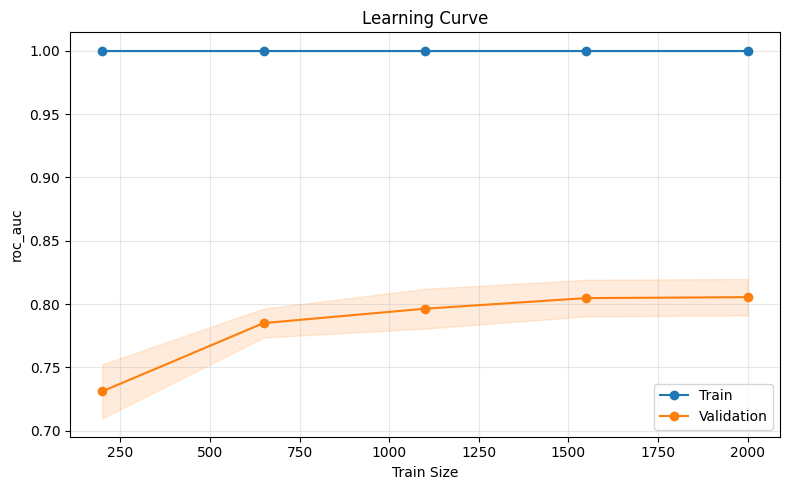

In [40]:
plot_learning_curve(model, X_train, y_train['target'], scoring='roc_auc')

In [41]:
X_train.shape

(3000, 30)